In [1]:
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# # Getting device
run_gpu = 0    # 0,1,2,3,...
dev = 'cuda:' + str(run_gpu)
# dev='cpu'

print(torch.cuda.is_available())
device = torch.device(dev if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))
# dev = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
dev

True
Using device: cuda:0	NVIDIA GeForce RTX 3070


'cuda:0'

In [3]:
class MLP(torch.nn.Module):
     def __init__(self, input_dim, output_dim, dev='cpu', hidden_dims=[]):
        super(MLP, self).__init__()
        self.linear_set = []
        if len(hidden_dims) == 0:
            self.linear_set.append(torch.nn.Linear(input_dim, output_dim).to(dev))
        else:
            for ilayer in range(len(hidden_dims) + 1):
                if ilayer == 0:
                    dim1 = input_dim
                    dim2 = hidden_dims[0]
                elif ilayer == len(hidden_dims):
                    dim1 = hidden_dims[ilayer-1]
                    dim2 = output_dim
                else:
                    dim1 = hidden_dims[ilayer-1]
                    dim2 = hidden_dims[ilayer]
                self.linear_set.append(torch.nn.Linear(dim1, dim2).to(dev))
#         print(len(self.linear_set))
     def forward(self, x):
        for ilayer in range(len(self.linear_set) - 1):
#             print(ilayer)
            x = torch.sigmoid(self.linear_set[ilayer](x))

        outputs = self.linear_set[-1](x)
        return outputs

dim = 2
model = MLP(input_dim=dim, output_dim=dim, dev=dev, hidden_dims=[10, 5, 5])
# test
model(torch.tensor([1,1], dtype=torch.float32).to(dev))

tensor([0.1970, 0.6784], device='cuda:0', grad_fn=<ViewBackward0>)

## Problem #1


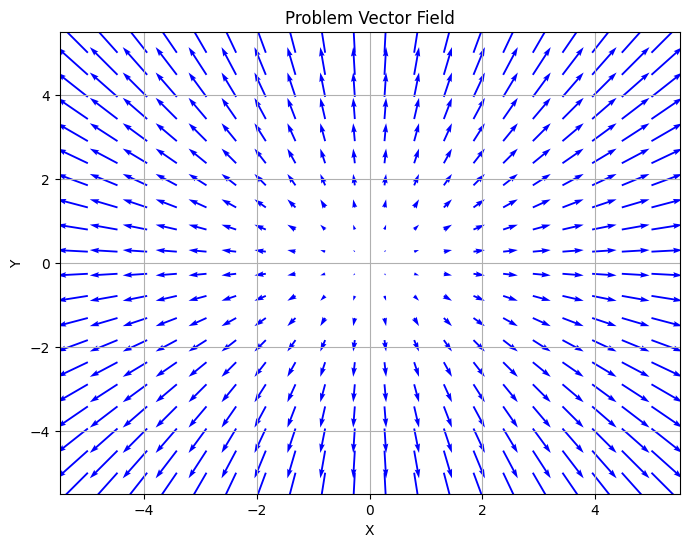

In [4]:
# quiver usage example
# Define the grid
x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)   # 20x20, 20x20
X = X.reshape([-1,1])   # 20^2 x 1
Y = Y.reshape([-1,1])   # 20^2 x 1

# Define vector field function
def vector_field(x, y):
    # Define vector components (you can replace these with any functions)
    u = x*.05
    v = y*.05
#     v = np.zeros_like(y)
    return u, v

# Compute vector components
U, V = vector_field(X, Y)

# Plot the vector field
plt.figure(figsize=(8, 6))
plt.quiver(X, Y, U, V, scale=5, color='blue', width=0.003)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Problem Vector Field')
plt.grid(True)
plt.show()

In [5]:
losses1 = []

batch_size = 100
epochs = 20_000
learning_rate = 0.1
dim = 2

# original model1
model1 = MLP(input_dim=dim, output_dim=dim, dev=dev, hidden_dims=[10, 10, 5, 5])
params1 = []
for param_ft in [model1.linear_set[i].parameters() for i in range(len(model1.linear_set))]:
    for param in param_ft:
#         print(param)
        params1.append(param)

optimizer1 = torch.optim.SGD(params1, lr=learning_rate)
# optimizer1 = torch.optim.SGD(model1.parameters(), lr=learning_rate)

for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    X = X.reshape([-1,1])   # 20^2 x 1
    Y = Y.reshape([-1,1])   # 20^2 x 1

    shuffle = np.random.permutation(X.shape[0])
    X_shuffled = X[shuffle]
    Y_shuffled = Y[shuffle]

    for i in range(0, X.shape[0], batch_size):
        X_batch = X_shuffled[i:i+batch_size]
        Y_batch = Y_shuffled[i:i+batch_size]

        input_model = torch.cat([torch.tensor(X_batch, dtype=torch.float32), \
                torch.tensor(Y_batch, dtype=torch.float32)], \
                axis=1).to(dev)
#     print(input_model.device)

        optimizer1.zero_grad() # Setting our stored gradients equal to zero

        output1 = model1(input_model)

        loss_fn1 = torch.nn.MSELoss()

        U_batch, V_batch = vector_field(X_batch, Y_batch)

        loss1 = loss_fn1(output1, torch.tensor(np.concatenate([U_batch, V_batch], axis=1), device=dev, dtype=torch.float32))

        loss1.backward() # Computes the gradient of the given tensor w.r.t. graph leaves

        optimizer1.step() # Updates weights and biases with the optimizer1 (SGD)
        
        losses1.append(loss1.cpu().detach().numpy().tolist())

print()
print("Last loss of original model1: ", losses1[-1])
# print(model1(input_model))

Training Epochs: 100%|██████████| 20000/20000 [02:11<00:00, 152.38it/s]


Last loss of original model1:  7.549904694315046e-05


In [6]:
losses2 = []

batch_size = 100
epochs = 50_000
learning_rate = 0.1
dim = 2

# original model2
model2 = MLP(input_dim=dim, output_dim=dim, dev=dev, hidden_dims=[10, 10, 5, 5])
params2 = []
for param_ft in [model2.linear_set[i].parameters() for i in range(len(model2.linear_set))]:
    for param in param_ft:
#         print(param)
        params2.append(param)

optimizer2 = torch.optim.SGD(params2, lr=learning_rate)
# optimizer2 = torch.optim.SGD(model2.parameters(), lr=learning_rate)

for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    X = X.reshape([-1,1])   # 20^2 x 1
    Y = Y.reshape([-1,1])   # 20^2 x 1
    input_model = torch.cat([torch.tensor(X, dtype=torch.float32), \
                torch.tensor(Y, dtype=torch.float32)], \
                axis=1).to(dev)
#     print(input_model.device)

    optimizer2.zero_grad() # Setting our stored gradients equal to zero

    output2 = model2(input_model)

    loss_fn2 = torch.nn.MSELoss()

    U, V = vector_field(X, Y)

    loss2 = loss_fn2(output2, torch.tensor(np.concatenate([U, V], axis=1), device=dev, dtype=torch.float32))

    loss2.backward() # Computes the gradient of the given tensor w.r.t. graph leaves

    optimizer2.step() # Updates weights and biases with the optimizer2 (SGD)
    
    losses2.append(loss2.cpu().detach().numpy().tolist())

print()
print("Last loss of original model2: ", losses2[-1])
# print(model2(input_model))

Training Epochs: 100%|██████████| 50000/50000 [01:11<00:00, 699.36it/s]


Last loss of original model2:  0.0003340457333251834


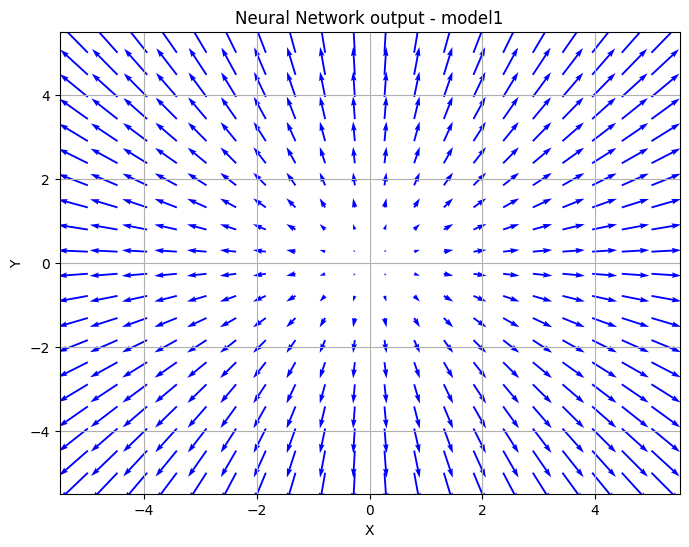

In [7]:
x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)   # 20x20, 20x20
input_data = np.concatenate([X.reshape([-1,1]), Y.reshape([-1,1])], axis=1)  # 20^2 x 2
output_data = model1(torch.tensor(input_data, device=dev, dtype=torch.float32))
# output_data
U = output_data.cpu().detach().numpy()[:,0].reshape([20,20])
V = output_data.cpu().detach().numpy()[:,1].reshape([20,20])

# Plot the vector field
plt.figure(figsize=(8, 6))
plt.quiver(X, Y, U, V, scale=5, color='blue', width=0.003)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Neural Network output - model1')
plt.grid(True)
plt.show()

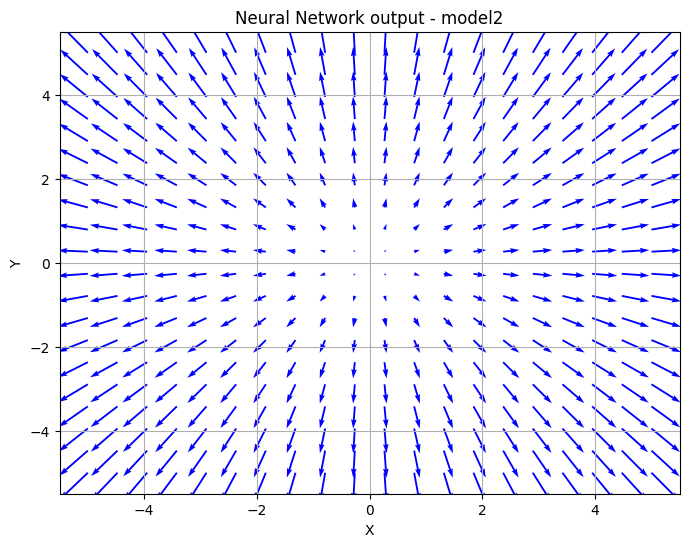

In [8]:
x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)   # 20x20, 20x20
input_data = np.concatenate([X.reshape([-1,1]), Y.reshape([-1,1])], axis=1)  # 20^2 x 2
output_data = model1(torch.tensor(input_data, device=dev, dtype=torch.float32))
# output_data
U = output_data.cpu().detach().numpy()[:,0].reshape([20,20])
V = output_data.cpu().detach().numpy()[:,1].reshape([20,20])

# Plot the vector field
plt.figure(figsize=(8, 6))
plt.quiver(X, Y, U, V, scale=5, color='blue', width=0.003)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Neural Network output - model2')
plt.grid(True)
plt.show()

In [ ]:
losses1 = []
losses2 = []

epochs = 50_000
learning_rate = 0.1
dim = 2

# original model1
model1 = MLP(input_dim=dim, output_dim=dim, dev=dev, hidden_dims=[10, 10, 5, 5])
params1 = []
for param_ft in [model1.linear_set[i].parameters() for i in range(len(model1.linear_set))]:
    for param in param_ft:
#         print(param)
        params1.append(param)

optimizer1 = torch.optim.SGD(params1, lr=learning_rate)
# optimizer1 = torch.optim.SGD(model1.parameters(), lr=learning_rate)

# modified model2
model2 = MLP(input_dim=dim, output_dim=dim, dev=dev, hidden_dims=[40, 40, 20, 20, 10, 10, 5])
params2 = []
for param_ft in [model2.linear_set[i].parameters() for i in range(len(model2.linear_set))]:
    for param in param_ft:
        params2.append(param)
optimizer2 = torch.optim.SGD(params2, lr=learning_rate)


for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    X = X.reshape([-1,1])   # 20^2 x 1
    Y = Y.reshape([-1,1])   # 20^2 x 1
    input_model = torch.cat([torch.tensor(X, dtype=torch.float32), \
                torch.tensor(Y, dtype=torch.float32)], \
                axis=1).to(dev)
#     print(input_model.device)

    optimizer1.zero_grad() # Setting our stored gradients equal to zero
    optimizer2.zero_grad() # Setting our stored gradients equal to zero

    output1 = model1(input_model)
    output2 = model2(input_model)

    loss_fn1 = torch.nn.MSELoss()
    loss_fn2 = torch.nn.MSELoss()

    U, V = vector_field(X, Y)

    loss1 = loss_fn1(output1, torch.tensor(np.concatenate([U, V], axis=1), device=dev, dtype=torch.float32))
    loss2 = loss_fn2(output2, torch.tensor(np.concatenate([U, V], axis=1), device=dev, dtype=torch.float32))

    loss1.backward() # Computes the gradient of the given tensor w.r.t. graph leaves
    loss2.backward() # Computes the gradient of the given tensor w.r.t. graph leaves

    optimizer1.step() # Updates weights and biases with the optimizer1 (SGD)
    optimizer2.step() # Updates weights and biases with the optimizer1 (SGD)
    
    losses1.append(loss1.cpu().detach().numpy().tolist())
    losses2.append(loss2.cpu().detach().numpy().tolist())

print()
print("Last loss of original model1: ", losses1[-1])
print("Last loss of modified model2 : ", losses2[-1])
# print(model1(input_model))

In [ ]:
# Loss of original model
plt.plot(range(epochs), losses1)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss of original model')
plt.show()

# Loss of modified model(relu)
plt.plot(range(epochs), losses2)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss of relu model')
plt.show()

In [ ]:
x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)   # 20x20, 20x20
input_data = np.concatenate([X.reshape([-1,1]), Y.reshape([-1,1])], axis=1)  # 20^2 x 2
output_data = model1(torch.tensor(input_data, device=dev, dtype=torch.float32))
# output_data
U = output_data.cpu().detach().numpy()[:,0].reshape([20,20])
V = output_data.cpu().detach().numpy()[:,1].reshape([20,20])

# Plot the vector field
plt.figure(figsize=(8, 6))
plt.quiver(X, Y, U, V, scale=5, color='blue', width=0.003)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original Neural Network output (sigmoid)')
plt.grid(True)
plt.show()

In [ ]:
x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)   # 20x20, 20x20
input_data = np.concatenate([X.reshape([-1,1]), Y.reshape([-1,1])], axis=1)  # 20^2 x 2
output_data = model2(torch.tensor(input_data, device=dev, dtype=torch.float32))
# output_data
U = output_data.cpu().detach().numpy()[:,0].reshape([20,20])
V = output_data.cpu().detach().numpy()[:,1].reshape([20,20])

# Plot the vector field
plt.figure(figsize=(8, 6))
plt.quiver(X, Y, U, V, scale=5, color='blue', width=0.003)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Modified Neural Network output')
plt.grid(True)
plt.show()

What is the problem? Can you fix it?

## Problem #2

In [ ]:
# Define vector field function
def vector_field(x, y, t):
    # Define vector components (you can replace these with any functions)
    u = x*.05
    if t == 0:
        v = y*.05
    else:
        v = np.zeros_like(y)
    return u, v


# quiver usage example
# Define the grid
x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)   # 20x20, 20x20
X = X.reshape([-1,1])   # 20^2 x 1
Y = Y.reshape([-1,1])   # 20^2 x 1

# Compute vector components
U, V = vector_field(X, Y, t=0)

# Plot the vector field
plt.figure(figsize=(8, 6))
plt.quiver(X, Y, U, V, scale=5, color='blue', width=0.003)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Groundtruth Vector Field t=0')
plt.grid(True)
plt.show()

# Compute vector components
U, V = vector_field(X, Y, t=1)

# Plot the vector field
plt.figure(figsize=(8, 6))
plt.quiver(X, Y, U, V, scale=5, color='blue', width=0.003)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Groundtruth Vector Field t=1')
plt.grid(True)
plt.show()


In [ ]:
class MLP2(torch.nn.Module):
     def __init__(self, input_dim, output_dim, dev='cpu', hidden_dims=[]):
        super(MLP2, self).__init__()
        self.linear_set = []
        if len(hidden_dims) == 0:
            self.linear_set.append(torch.nn.Linear(input_dim, output_dim).to(dev))
        else:
            for ilayer in range(len(hidden_dims) + 1):
                if ilayer == 0:
                    dim1 = input_dim
                    dim2 = hidden_dims[0]
                elif ilayer == len(hidden_dims):
                    dim1 = hidden_dims[ilayer-1]
                    dim2 = output_dim
                else:
                    dim1 = hidden_dims[ilayer-1]
                    dim2 = hidden_dims[ilayer]
                self.linear_set.append(torch.nn.Linear(dim1, dim2).to(dev))
            self.linear_set = torch.nn.ModuleList(self.linear_set)
#         print(len(self.linear_set))
     def forward(self, x):
        for ilayer in range(len(self.linear_set) - 1):
            x = torch.sigmoid(self.linear_set[ilayer](x))
            # x = torch.relu(self.linear_set[ilayer](x))
        outputs = self.linear_set[-1](x)
        return outputs

dim = 2
model = MLP2(input_dim=dim, output_dim=dim, dev=dev, hidden_dims=[10, 5, 5])
# test
model(torch.tensor([1,1], dtype=torch.float32).to(dev))

In [ ]:
class MLP2_relu(torch.nn.Module):
     def __init__(self, input_dim, output_dim, dev='cpu', hidden_dims=[]):
        super(MLP2_relu, self).__init__()
        self.linear_set = []
        if len(hidden_dims) == 0:
            self.linear_set.append(torch.nn.Linear(input_dim, output_dim).to(dev))
        else:
            for ilayer in range(len(hidden_dims) + 1):
                if ilayer == 0:
                    dim1 = input_dim
                    dim2 = hidden_dims[0]
                elif ilayer == len(hidden_dims):
                    dim1 = hidden_dims[ilayer-1]
                    dim2 = output_dim
                else:
                    dim1 = hidden_dims[ilayer-1]
                    dim2 = hidden_dims[ilayer]
                self.linear_set.append(torch.nn.Linear(dim1, dim2).to(dev))
            self.linear_set = torch.nn.ModuleList(self.linear_set)
#         print(len(self.linear_set))
     def forward(self, x):
        for ilayer in range(len(self.linear_set) - 1):
            # x = torch.sigmoid(self.linear_set[ilayer](x))
            x = torch.relu(self.linear_set[ilayer](x))
        outputs = self.linear_set[-1](x)
        return outputs

dim = 2
model = MLP2_relu(input_dim=dim, output_dim=dim, dev=dev, hidden_dims=[10, 5, 5])
# test
model_relu(torch.tensor([1,1], dtype=torch.float32).to(dev))

In [ ]:
losses = []
losses_relu = []

epochs = 50_000
# learning_rate = 0.01
learning_rate = 0.1
dim = 2

spacetime_dim = dim + 1
model = MLP2(input_dim=spacetime_dim, output_dim=dim, \
            dev=dev, hidden_dims=[50, 10, 5, 5]).to(dev)


optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# time_step = 1.
time_step = 10
# time_step = 5

model_relu = MLP2_relu(input_dim=spacetime_dim, output_dim=dim, \
            dev=dev, hidden_dims=[50, 10, 5, 5]).to(dev)
optimizer_relu = torch.optim.SGD(model_relu.parameters(), lr=learning_rate)


for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    X = X.reshape([-1,1])   # 20^2 x 1
    Y = Y.reshape([-1,1])   # 20^2 x 1
    frame=0
    input_model1 = torch.cat([torch.tensor(X, device=dev, dtype=torch.float32), \
                torch.tensor(Y, device=dev, dtype=torch.float32), \
                time_step*frame*torch.ones(len(X),1, device=dev, dtype=torch.float32)], \
                axis=1)
    U1, V1 = vector_field(X, Y, t=frame)

    frame=1
    input_model2 = torch.cat([torch.tensor(X, device=dev, dtype=torch.float32), \
                torch.tensor(Y, device=dev, dtype=torch.float32), \
                time_step*frame*torch.ones(len(X),1, device=dev, dtype=torch.float32)], \
                axis=1)

    U2, V2 = vector_field(X, Y, t=frame)

    input_model = torch.cat([input_model1, input_model2])
    U = np.concatenate([U1, U2])
    V = np.concatenate([V1, V2])

    optimizer.zero_grad() # Setting our stored gradients equal to zero
    optimizer_relu.zero_grad() # Setting our stored gradients equal to zero

    output = model(input_model)
    output_relu = model_relu(input_model)

    loss_fn = torch.nn.MSELoss()
    loss_fn_relu = torch.nn.MSELoss()

    loss = loss_fn(output, \
                   torch.tensor(np.concatenate([U, V], axis=1), device=dev, dtype=torch.float32))

    loss_relu = loss_fn_relu(output_relu, \
                   torch.tensor(np.concatenate([U, V], axis=1), device=dev, dtype=torch.float32))
    
    loss.backward() # Computes the gradient of the given tensor w.r.t. graph leaves
    loss_relu.backward() # Computes the gradient of the given tensor w.r.t. graph leaves

    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    optimizer_relu.step() # Updates weights and biases with the optimizer (SGD)
    
    losses.append(loss.cpu().detach().numpy().tolist())
    losses_relu.append(loss_relu.cpu().detach().numpy().tolist())

print()
print("Last loss of original model: ", losses[-1])
print("Last loss of relu model : ", losses_relu[-1])
# print(model(input_model))

In [ ]:
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss of original model')
plt.show()

plt.plot(range(epochs), losses_relu)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss of relu model')
plt.show()

In [ ]:
x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)   # 20x20, 20x20
X = X.reshape([-1,1])   # 20^2 x 1
Y = Y.reshape([-1,1])   # 20^2 x 1

frame = 0
input_data = np.concatenate([X, Y, time_step*frame*np.ones_like(X)], axis=1)  # 20^2 x 2
# input_data = np.concatenate([X, Y], axis=1)  # 20^2 x 2
output_data = model(torch.tensor(input_data, device=dev, dtype=torch.float32))
# output_data
U = output_data.cpu().detach().numpy()[:,0].reshape([20,20])
V = output_data.cpu().detach().numpy()[:,1].reshape([20,20])

# Plot the vector field
plt.figure(figsize=(8, 6))
plt.quiver(X, Y, U, V, scale=5, color='blue', width=0.003)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original Neural Network output (sigmoid)')
plt.grid(True)
plt.show()

frame = 1
input_data = np.concatenate([X, Y, time_step*frame*np.ones_like(X)], axis=1)  # 20^2 x 2
# input_data = np.concatenate([X, Y], axis=1)  # 20^2 x 2
output_data = model(torch.tensor(input_data, device=dev, dtype=torch.float32))
# output_data
U = output_data.cpu().detach().numpy()[:,0].reshape([20,20])
V = output_data.cpu().detach().numpy()[:,1].reshape([20,20])

# Plot the vector field
plt.figure(figsize=(8, 6))
plt.quiver(X, Y, U, V, scale=5, color='blue', width=0.003)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original Neural Network output (sigmoid)')
plt.grid(True)
plt.show()

In [ ]:
x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)   # 20x20, 20x20
X = X.reshape([-1,1])   # 20^2 x 1
Y = Y.reshape([-1,1])   # 20^2 x 1

frame = 0
input_data = np.concatenate([X, Y, time_step*frame*np.ones_like(X)], axis=1)  # 20^2 x 2
# input_data = np.concatenate([X, Y], axis=1)  # 20^2 x 2
output_data = model_relu(torch.tensor(input_data, device=dev, dtype=torch.float32))
# output_data
U = output_data.cpu().detach().numpy()[:,0].reshape([20,20])
V = output_data.cpu().detach().numpy()[:,1].reshape([20,20])

# Plot the vector field
plt.figure(figsize=(8, 6))
plt.quiver(X, Y, U, V, scale=5, color='blue', width=0.003)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Modified Neural Network output (relu)')
plt.grid(True)
plt.show()

frame = 1
input_data = np.concatenate([X, Y, time_step*frame*np.ones_like(X)], axis=1)  # 20^2 x 2
# input_data = np.concatenate([X, Y], axis=1)  # 20^2 x 2
output_data = model_relu(torch.tensor(input_data, device=dev, dtype=torch.float32))
# output_data
U = output_data.cpu().detach().numpy()[:,0].reshape([20,20])
V = output_data.cpu().detach().numpy()[:,1].reshape([20,20])

# Plot the vector field
plt.figure(figsize=(8, 6))
plt.quiver(X, Y, U, V, scale=5, color='blue', width=0.003)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Modified Neural Network output (relu)')
plt.grid(True)
plt.show()

The result is not satisfactory. Can you improve it?